# Ordinary Least Square

In [1]:
%matplotlib inline

In [3]:
#Data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns; sns.reset_orig()
from Residual_Visualization import regression_residual_plots

#Machine Learning
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


#Helpers
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

//anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
//anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
//anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
//anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
//anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib

-----------------

In [4]:
df = pd.read_csv("/Users/duc_hoang/Box Sync/Fermilab Summer Research/CNN-Architectural-Analysis/MINERvA-Vertex-Finding/Data/Combined-population/Combined-populations-with-labels.csv",
                 index_col = 0)

In [5]:
df = df.drop('group', axis=1)
#Select out the healthy parts
df = df[df["final_accuracy"] >= 0.100533]

Text(0.5, 1.0, 'Transformed Accuracy')

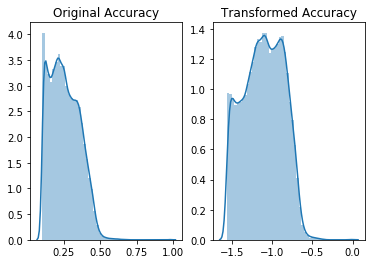

In [6]:
# normalize the exponential data with boxcox
normalized_accuracy = stats.boxcox(df["final_accuracy"])

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(df['final_accuracy'], ax=ax[0])
ax[0].set_title("Original Accuracy")
ax[0].set(xlabel='')
sns.distplot(normalized_accuracy[0], ax=ax[1])
ax[1].set_title("Transformed Accuracy")

In [7]:
df["transformed_accuracy"] = normalized_accuracy[0]

---------------

In [8]:
#Feature + target
X = df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy',"transformed_accuracy"]) #Features
y = df["transformed_accuracy"]

#Extract initial feature names and index for later use
initial_feature_names = X.columns #Save the feature names
initial_index = X.index

In [9]:
def generate_feature_names(power,initial_feature_names,initial_index, transformed_data):
    """
    Since the fit_transform function does not automatically generate the feature names for the interaction term,
    this function creates a feature name list and append it to the the transformed features array.
    
    Arguments:
    power:                 -- numpy array of dimension (total number of regressors, initial number of regressors) 
                           -- indicates the power of each initial feature of each column of transformed_data 
    
    initial_feature_names: -- pandas index object 
                           -- contains original names of features before transformed
    
    initial_index:         -- pandas index object 
                           -- maintain index of transformed_data
                           
    transformed_data:      -- numpy array of transformed data including the interaction terms
    
    Returns: 
    new_dataframe -- pandas dataframe with the columns names for interaction terms 
    """
    new_feature_names = [] #to save all the new feature names
    
    #Loop through power to generate new feature names
    for i in range(power.shape[0]):
        feature_name = ''
        for j in range(len(initial_feature_names)):
            if power[i,j]: #If the feature should be included then add to feature names
                if not feature_name: #If feature name is still empty
                    feature_name += initial_feature_names[j]
                else:
                    feature_name = feature_name + "*" + initial_feature_names[j]
        #Add feature name to new list a the end
        new_feature_names.append(feature_name)

    new_dataframe = pd.DataFrame(transformed_data, columns=new_feature_names,index=initial_index)
    
    return new_dataframe

In [10]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
X = scaler.transform(X) 

In [11]:
poly = PolynomialFeatures(interaction_only = True, include_bias = False)
X = poly.fit_transform(X) #Create interaction terms 

In [12]:
#X now should be the new dataframe with columns name
X = generate_feature_names(poly.powers_,initial_feature_names,initial_index, X)

#Fit model
model = sm.OLS(y, X)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     transformed_accuracy   R-squared (uncentered):                   0.966
Model:                              OLS   Adj. R-squared (uncentered):              0.966
Method:                   Least Squares   F-statistic:                              3311.
Date:                  Mon, 26 Aug 2019   Prob (F-statistic):                        0.00
Time:                          10:49:28   Log-Likelihood:                          8410.7
No. Observations:                 57755   AIC:                                 -1.583e+04
Df Residuals:                     57259   BIC:                                 -1.138e+04
Df Model:                           496                                                  
Covariance Type:              nonrobust                                                  
==============================================================================================================================================
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
avg_IP_neurons                                                                 2.8432      0.020    138.989      0.000       2.803       2.883
avg_IP_weights                                                                 0.0436      0.005      7.971      0.000       0.033       0.054
avg_concat_width                                                              -0.1428      0.004    -32.219      0.000      -0.151      -0.134
avg_grid_reduction_area_consecutive                                           -0.0102      0.009     -1.114      0.265      -0.028       0.008
avg_grid_reduction_area_total                                                  0.0465      0.008      5.577      0.000       0.030       0.063
avg_grid_reduction_height_consecutive                                          0.0409      0.008      5.282      0.000       0.026       0.056
avg_grid_reduction_height_total                                               -0.2437      0.008    -32.306      0.000      -0.258      -0.229
avg_grid_reduction_width_consecutive                                          -0.0753      0.007    -10.518      0.000      -0.089      -0.061
avg_grid_reduction_width_total                                                -0.1285      0.008    -15.884      0.000      -0.144      -0.113
avg_num_conv_features                                                          0.1417      0.007     20.595      0.000       0.128       0.155
avg_ratio_features_to_depth                                                   -0.0905      0.007    -12.729      0.000      -0.104      -0.077
avg_ratio_features_to_kerArea                                                  0.0146      0.006      2.305      0.021       0.002       0.027
avg_ratio_features_to_kerHeight                                                0.0043      0.004      0.954      0.340      -0.004       0.013
avg_ratio_features_to_kerWidth                                                -0.1540      0.004    -42.296      0.000      -0.161      -0.147
avg_ratio_kerArea_to_depth                                                    -0.0329      0.004     -8.383      0.000      -0.041      -0.025
avg_ratio_kerHeight_to_depth                                                   0.0071      0.003      2.355      0.019       0.001       0.013
avg_ratio_kerWidth_to_depth                                                    0.1027      0.004     28.826      0.000       0.096       0.110
avg_stride_h                                                                   0.3926      0.013     3

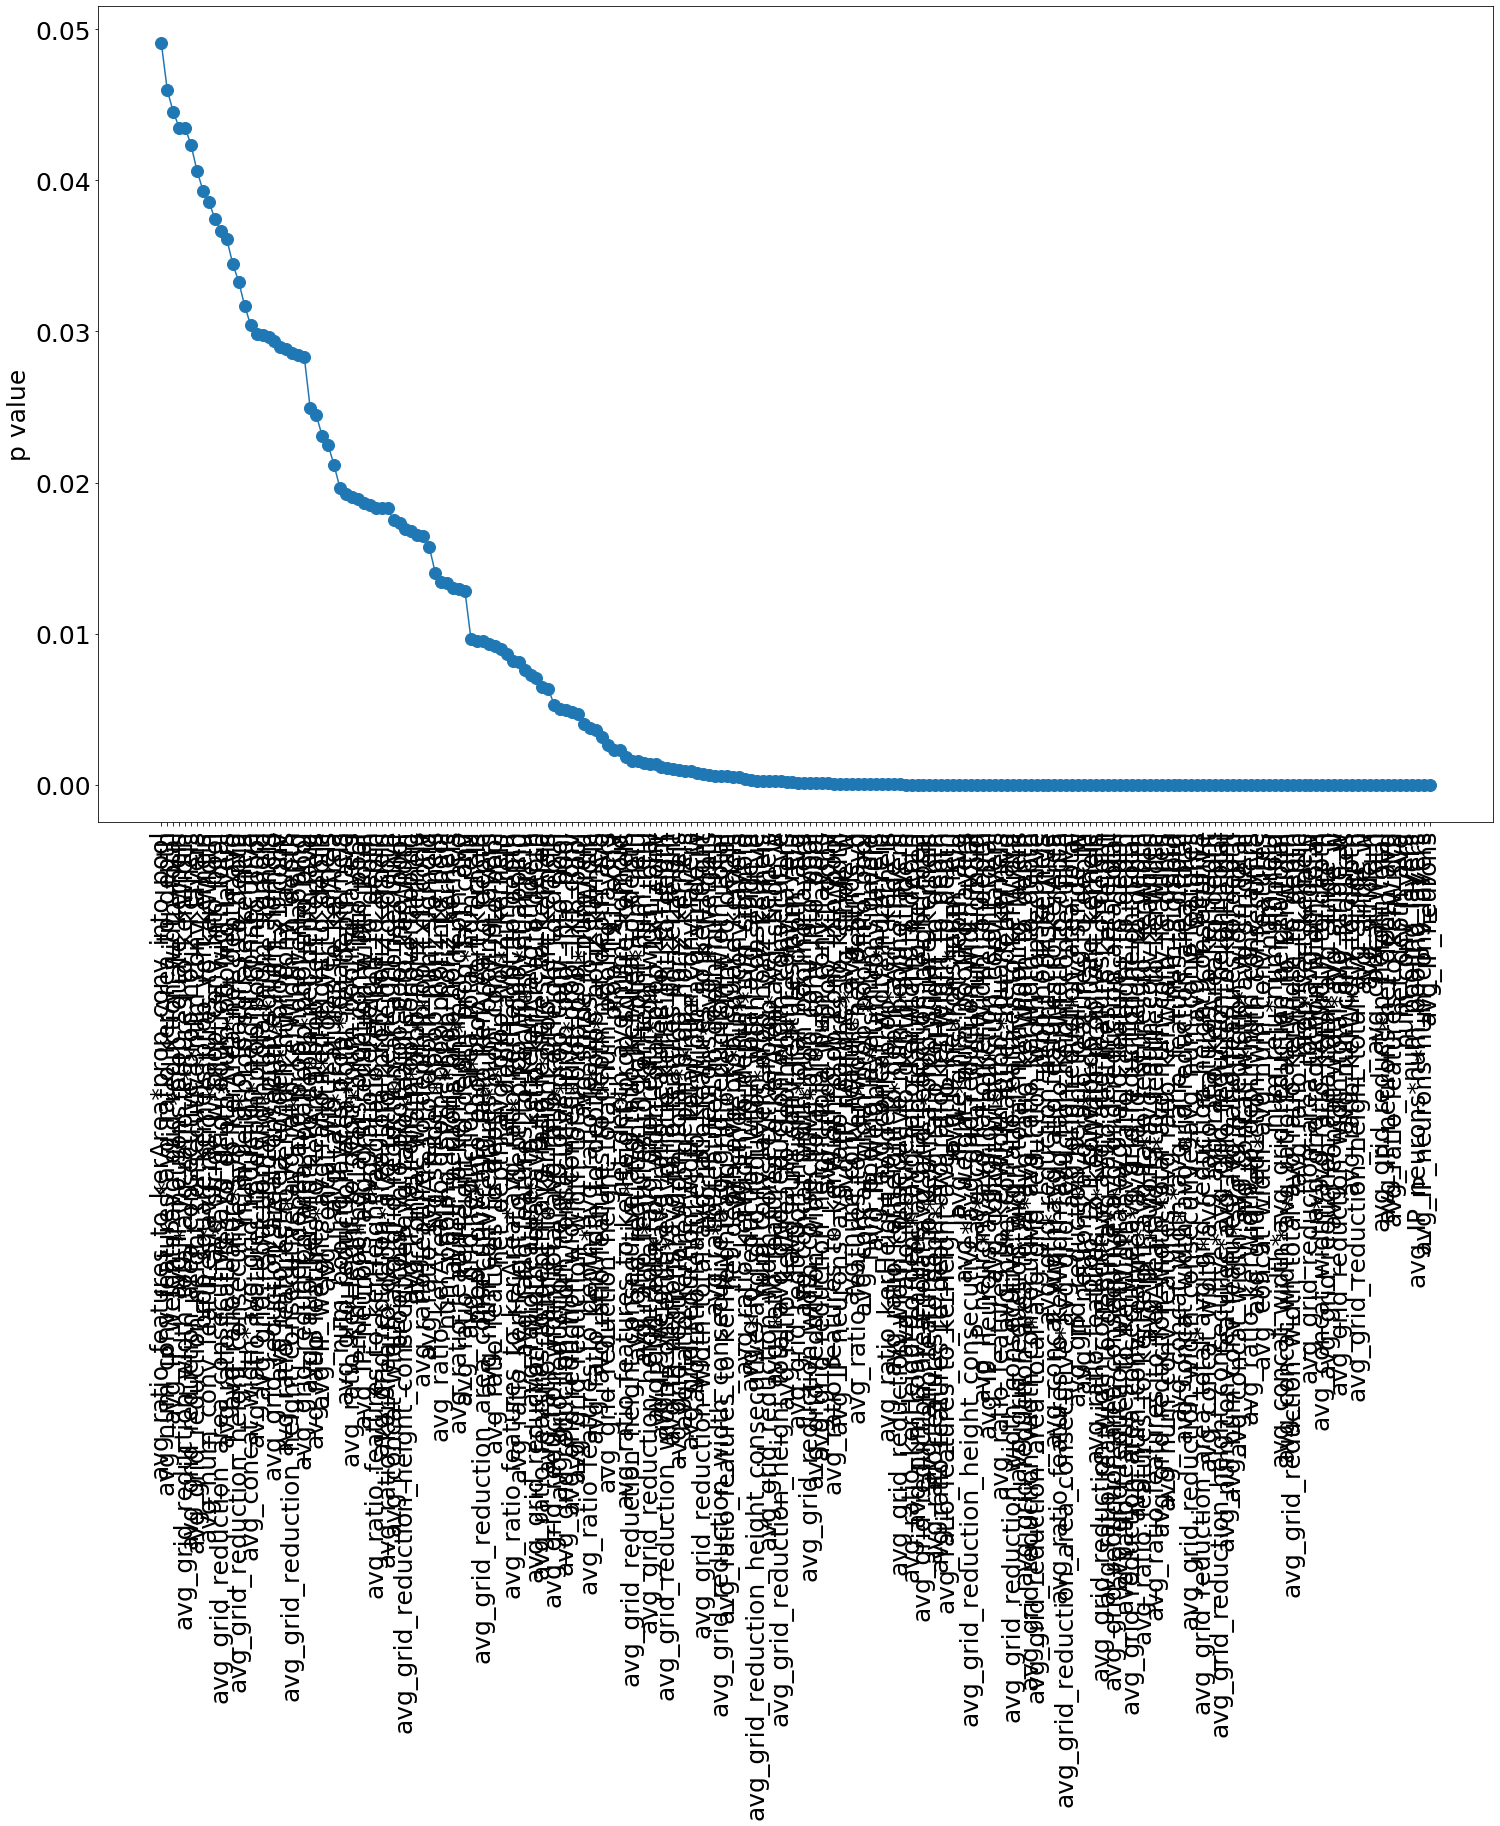

In [13]:
#Select out features that have p values < 0.05
important_p = results.summary2().tables[1][results.summary2().tables[1]["P>|t|"] < 0.05]

#Plot the sorted p-values
sorted_p_values = important_p.sort_values(by = "P>|t|", ascending = False)

#Position for x axis
pos = np.arange(sorted_p_values.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [25,15])
plt.plot(pos, sorted_p_values["P>|t|"], '-o', markersize = 12)
plt.xticks(pos, sorted_p_values.index, rotation = "vertical", fontsize = 25)
plt.yticks(fontsize=25)
plt.ylabel("p value", fontsize = 25)
plt.show()

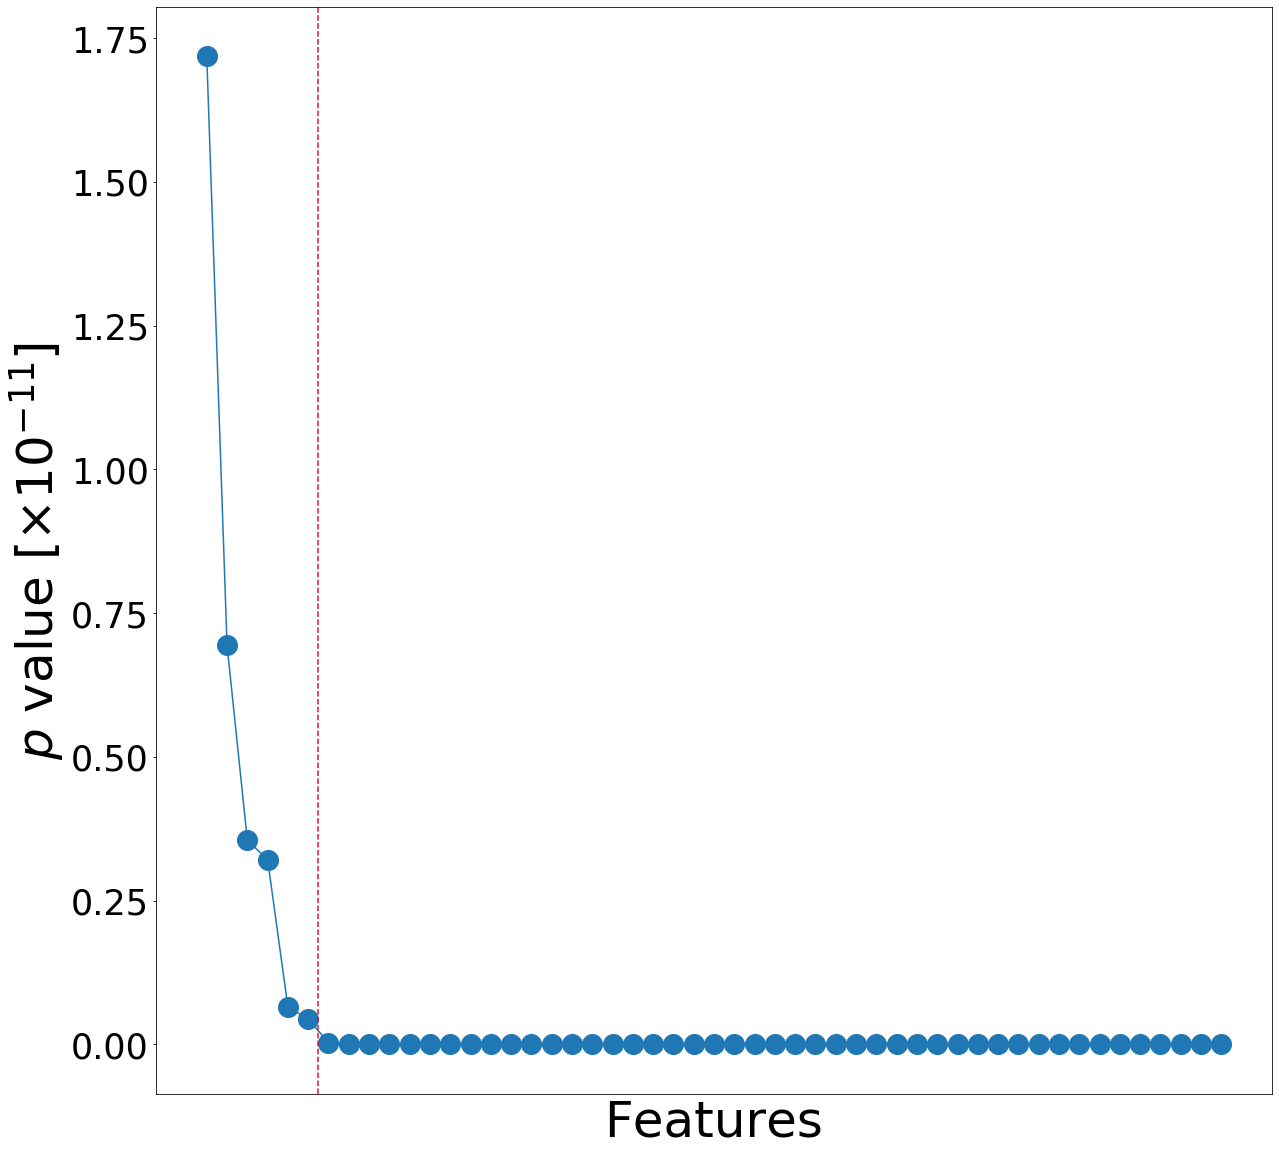

In [26]:
#Select out features that have p values < 0.05
important_p = results.summary2().tables[1][results.summary2().tables[1]["P>|t|"] < 2e-10]

#Plot the sorted p-values
sorted_p_values = important_p.sort_values(by = "P>|t|", ascending = False)

#Position for x axis
pos = np.arange(sorted_p_values.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [20,20])

#Main plot
plt.plot(pos, sorted_p_values["P>|t|"]*(1e+10), '-o', markersize = 20)

#X-axis
#plt.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off

plt.xlabel("Features", fontsize = 50)
plt.xticks([]*len(pos))
#y-axis
plt.yticks(fontsize=35)
plt.ylabel(r"$p$ value [$ \times 10^{-11}$]", fontsize = 50)

#Set cut off
plt.axvline(x = 6, ls = "--", c = "crimson")

plt.show()

In [14]:
important_p

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
avg_IP_neurons,2.843196,0.020456,138.989005,0.000000e+00,2.803102,2.883291
avg_IP_weights,0.043582,0.005468,7.970654,1.607291e-15,0.032865,0.054299
avg_concat_width,-0.142803,0.004432,-32.219342,9.972338e-226,-0.151490,-0.134116
avg_grid_reduction_height_total,-0.243667,0.007542,-32.306153,6.353520e-227,-0.258450,-0.228883
avg_grid_reduction_width_consecutive,-0.075274,0.007157,-10.518081,7.529246e-26,-0.089301,-0.061247
avg_grid_reduction_width_total,-0.128511,0.008091,-15.883726,1.086181e-56,-0.144369,-0.112653
avg_num_conv_features,0.141706,0.006881,20.594527,6.738416e-94,0.128220,0.155192
avg_ratio_features_to_depth,-0.090481,0.007108,-12.729146,4.572817e-37,-0.104413,-0.076549
avg_ratio_features_to_kerWidth,-0.154022,0.003641,-42.296246,0.000000e+00,-0.161159,-0.146884
avg_ratio_kerArea_to_depth,-0.032921,0.003927,-8.382627,5.291864e-17,-0.040618,-0.025223


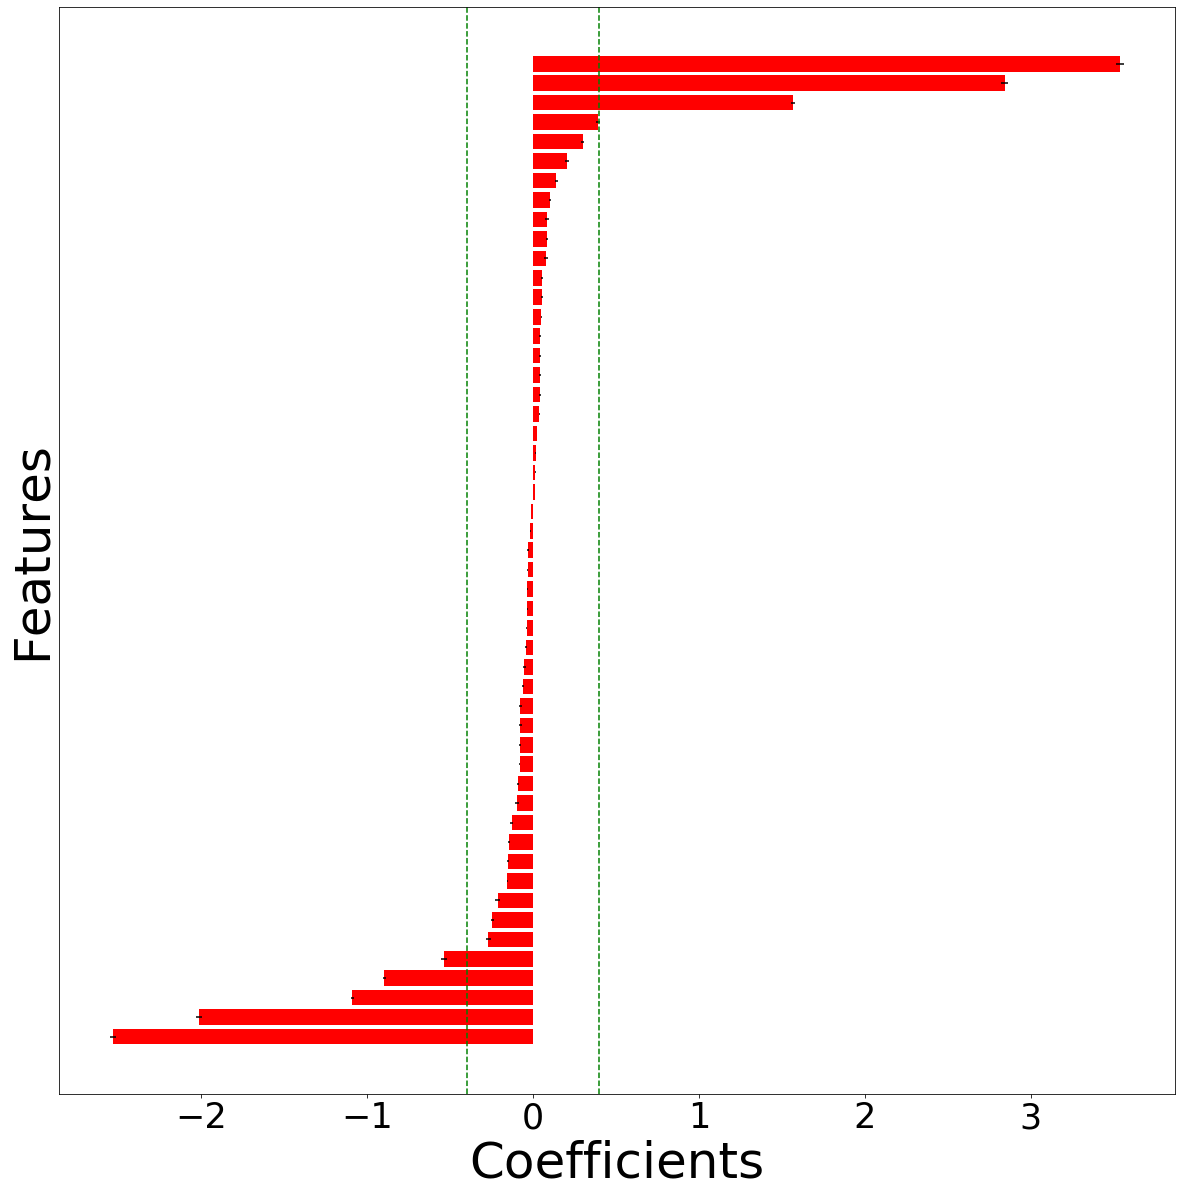

In [30]:
sorted_important_p = important_p.sort_values(by = "Coef.", ascending = True)
pos = np.arange(sorted_important_p.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [20,20])
plt.barh(pos, sorted_important_p['Coef.'], align='center', xerr = sorted_important_p['Std.Err.'], color = "red")
plt.yticks([]*len(pos))
plt.xlabel('Coefficients', fontsize = 50)
plt.ylabel("Features", fontsize = 50)
plt.xticks(fontsize= 35)

#Set cut off
plt.axvline(x = 0.4, ls = "--", c = "green")
plt.axvline(x = -0.4, ls = "--", c = "green")

plt.show()

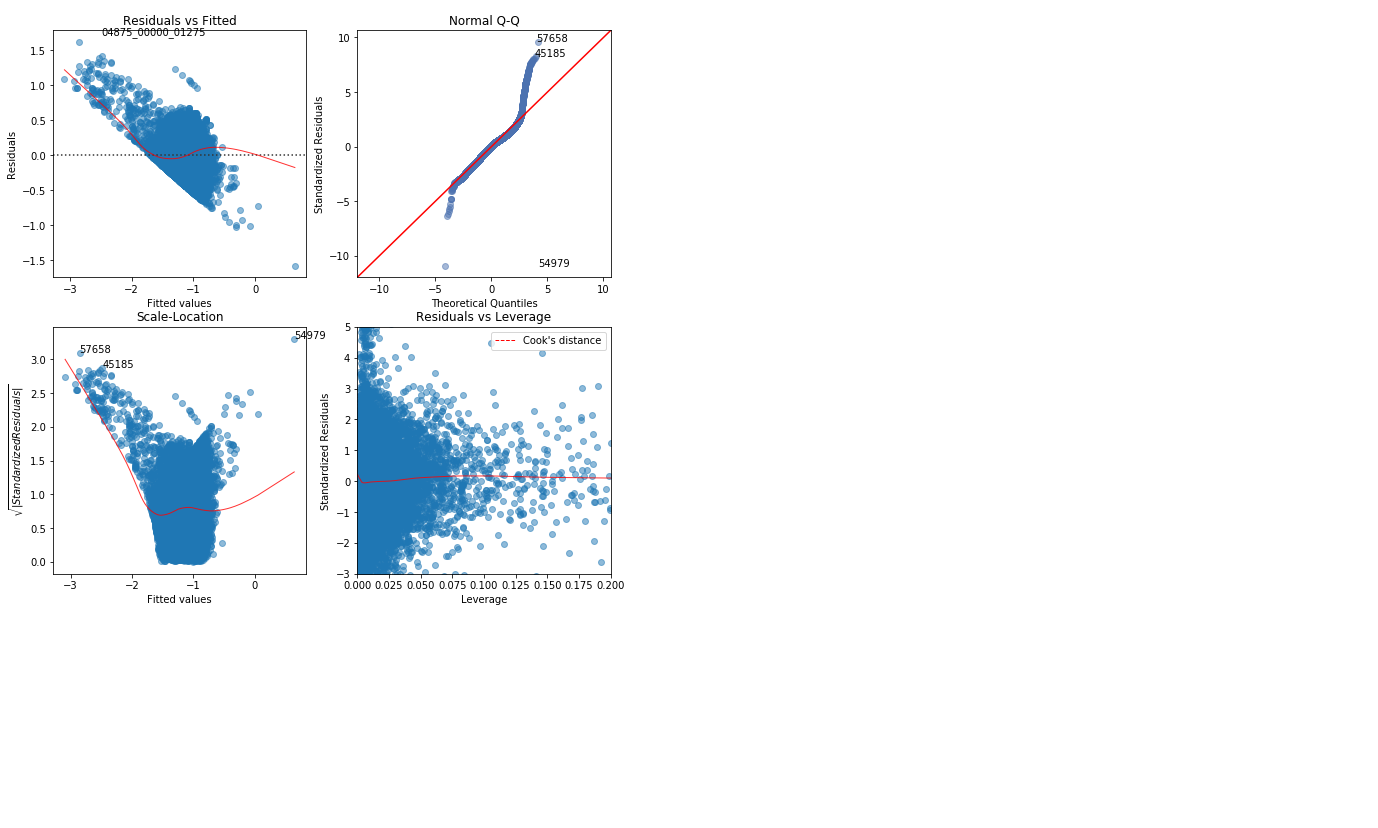

In [17]:
#Might be used to analyse the linear model
regression_residual_plots(results,'transformed_accuracy',df, size = [10,10])

In [20]:
important_p.sort_values(by = "Coef.", ascending = False)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
net_depth_avg,3.538265,0.025681,137.778020,0.000000e+00,3.487930,3.588600
avg_IP_neurons,2.843196,0.020456,138.989005,0.000000e+00,2.803102,2.883291
avg_IP_neurons*net_depth_avg,1.565661,0.010982,142.567618,0.000000e+00,1.544136,1.587185
avg_stride_h,0.392642,0.012624,31.103557,1.236623e-210,0.367899,0.417384
avg_stride_w,0.300035,0.009817,30.562294,1.694967e-203,0.280793,0.319276
avg_grid_reduction_area_total*avg_stride_h,0.206224,0.012242,16.845444,1.612681e-63,0.182229,0.230219
avg_num_conv_features,0.141706,0.006881,20.594527,6.738416e-94,0.128220,0.155192
avg_ratio_kerWidth_to_depth,0.102674,0.003562,28.826472,1.993796e-181,0.095693,0.109655
avg_grid_reduction_area_total*avg_grid_reduction_height_consecutive,0.083445,0.010444,7.989795,1.376637e-15,0.062975,0.103915
avg_concat_width*avg_grid_reduction_height_total,0.082657,0.006724,12.293410,1.087004e-34,0.069479,0.095836
